In [1]:
import warnings
warnings.filterwarnings("ignore")
import unicodecsv
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
from collections import defaultdict
from datetime import datetime
matplotlib.pylab.style.use("seaborn-colorblind")

In [2]:
def read_csv(filename):
    with open(filename, 'rb') as f:
        return list(unicodecsv.DictReader(f))

In [3]:
enrollments_file = "enrollments.csv"
daily_engagement_file = "daily_engagement.csv"
project_submissions_file = "project_submissions.csv"

In [4]:
enrollments = read_csv(enrollments_file)
daily_engagement = read_csv(daily_engagement_file)
project_submissions = read_csv(project_submissions_file)

In [5]:
def may_be_date(date): return None if date == '' else datetime.strptime(date, "%Y-%m-%d")
def may_be_int(value): return None if value == '' else int(float(value))
def may_be_float(value): return None if value == '' else float(value)
def may_be_bool(value): return None if value == '' else value == 'True'

In [6]:
proc_enr = [{
    "account_key": row["account_key"],
    "cancel_date": may_be_date(row["cancel_date"]),
    "days_to_cancel": may_be_int(row['days_to_cancel']),
    "is_canceled": may_be_bool(row["is_canceled"]),
    "is_udacity": may_be_bool(row["is_udacity"]),
    "join_date": may_be_date(row["join_date"]),
    "status": row["status"]
} for row in enrollments]
proc_eng = [{
    "account_key": row["acct"],
    "lessons_completed": may_be_float(row["lessons_completed"]),
    "num_courses_visited": may_be_float(row["num_courses_visited"]),
    "projects_completed": may_be_float(row["projects_completed"]),
    "total_minutes_visited": may_be_float(row["total_minutes_visited"]),
    "utc_date": may_be_date(row["utc_date"])
} for row in daily_engagement]
proc_sub = [{
    "account_key": row["account_key"],
    "assigned_rating": row["assigned_rating"],
    "completion_date": may_be_date(row["completion_date"]),
    "creation_date": may_be_date(row["creation_date"]),
    "lesson_key": row["lesson_key"],
    "processing_state": row["processing_state"]
} for row in project_submissions]

udacity_student_keys = set([row["account_key"] for row in proc_enr if row['is_udacity']])
proc_enr = filter(lambda row: row["account_key"] not in udacity_student_keys, proc_enr)
proc_eng = filter(lambda row: row["account_key"] not in udacity_student_keys, proc_eng)
proc_sub = filter(lambda row: row["account_key"] not in udacity_student_keys, proc_sub)

In [7]:
paid_students_temp = filter(lambda row: row["days_to_cancel"] is None or row["days_to_cancel"] > 7, proc_enr)
paid_students = dict()
for row in paid_students_temp:
    account, join_date = row["account_key"], row["join_date"]
    if account in paid_students:
        paid_students[account] = max(paid_students[account], join_date)
    else:
        paid_students[account] = join_date

In [8]:
len(paid_students)

995

In [9]:
def filter_func(row):
    account = row["account_key"]
    return (account in paid_students and (row["utc_date"] - paid_students[account]).days < 7 
            and (row["utc_date"] - paid_students[account]).days >= 0)
eng_paids_first_week = filter(filter_func, proc_eng)
len(eng_paids_first_week)

6919

In [10]:
accounts = defaultdict(list)
account_details = defaultdict(list)
for row in eng_paids_first_week:
    accounts[row["account_key"]].append(row["total_minutes_visited"])
    account_details[row["account_key"]].append(row)

In [11]:
def print_summary(metrics, eng_paids_first_week=eng_paids_first_week, print_some=False):
    accounts = defaultdict(list)
    account_details = defaultdict(list)
    for row in eng_paids_first_week:
        accounts[row["account_key"]].append(row[metrics])
        account_details[row["account_key"]].append(row)
    accounts_summary = {key: np.sum(value) for (key, value) in accounts.iteritems()}
    values = accounts_summary.values()
    print ("=====Summary of metric - %s" % metrics)
    print ("Mean: %s" % np.mean(values)) 
    print ("Std: %s" % np.std(values))
    print ("Max: %s" % np.max(values))
    print ("Min: %s" % np.min(values))
    
    if print_some:
        account_list = [(value, key) for (key, value) in accounts_summary.iteritems()]
        account_list.sort(reverse=True)
        print account_list[0:5]

        print account_details[account_list[0][1]]

In [12]:
for row in eng_paids_first_week:
    row['has_visit'] = 1 if row["num_courses_visited"] > 0 else 0
print_summary("has_visit", eng_paids_first_week)

=====Summary of metric - has_visit
Mean: 2.86733668342
Std: 2.25519800292
Max: 7
Min: 0


In [13]:
courses = ['746169184', '3176718735']
passed_students = set([row['account_key'] for row in proc_sub
              if row['lesson_key'] in courses and row['assigned_rating'] in ['PASSED', 'DISTINCTION']])
eng_passed = [row for row in eng_paids_first_week if row['account_key'] in passed_students]
eng_not_passed = [row for row in eng_paids_first_week if row['account_key'] not in passed_students]

print ("Passed=%s, Failed=%s" % (len(eng_passed), len(eng_not_passed)))

Passed=4527, Failed=2392


In [14]:
print_summary('total_minutes_visited', eng_passed)
print_summary('total_minutes_visited', eng_not_passed)

=====Summary of metric - total_minutes_visited
Mean: 394.586046484
Std: 448.499519327
Max: 3564.7332645
Min: 0.0
=====Summary of metric - total_minutes_visited
Mean: 143.326474267
Std: 269.538619011
Max: 1768.52274933
Min: 0.0


In [15]:
print_summary('lessons_completed', eng_passed)
print_summary('lessons_completed', eng_not_passed)

=====Summary of metric - lessons_completed
Mean: 2.05255023184
Std: 3.14222705558
Max: 36.0
Min: 0.0
=====Summary of metric - lessons_completed
Mean: 0.862068965517
Std: 2.54915994183
Max: 27.0
Min: 0.0


In [16]:
print_summary('has_visit', eng_passed)
print_summary('has_visit', eng_not_passed)

=====Summary of metric - has_visit
Mean: 3.38485316847
Std: 2.25882147092
Max: 7
Min: 0
=====Summary of metric - has_visit
Mean: 1.90517241379
Std: 1.90573144136
Max: 7
Min: 0


In [32]:
def histogram(metrics, data, bins=False):
    accounts = defaultdict(list)
    for row in data:
        accounts[row["account_key"]].append(row[metrics])
    accounts_summary = {key: np.sum(value) for (key, value) in accounts.iteritems()}
    values = accounts_summary.values()
    if bins:
        matplotlib.pylab.hist(values ,bins=bins)
    else:
        matplotlib.pylab.hist(values)
    matplotlib.pylab.plt.title("Histogram of %s" % metrics)

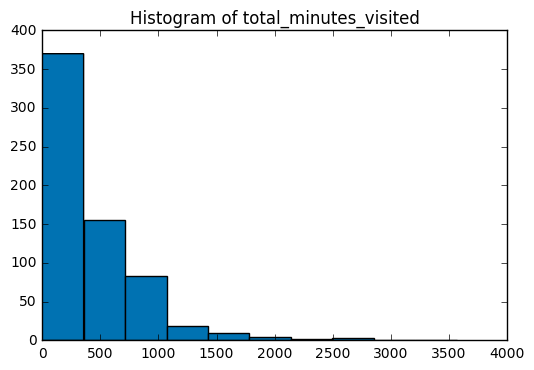

In [33]:
histogram('total_minutes_visited', eng_passed)

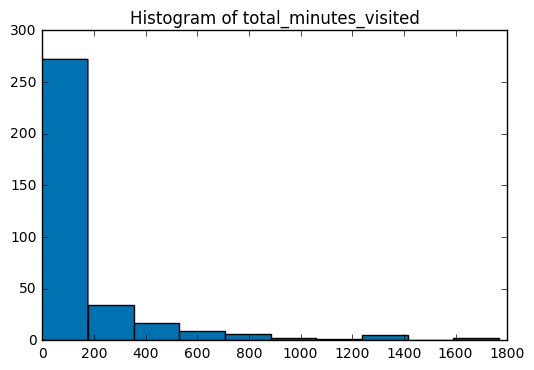

In [27]:
histogram('total_minutes_visited', eng_not_passed)

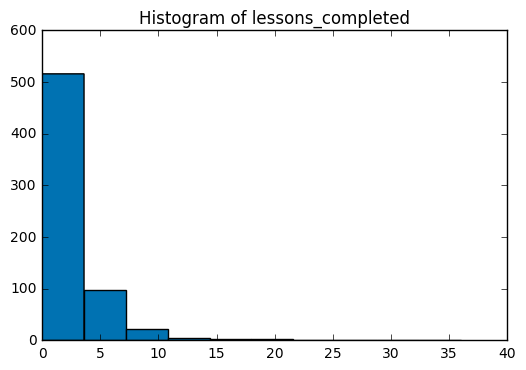

In [28]:
histogram('lessons_completed', eng_passed)

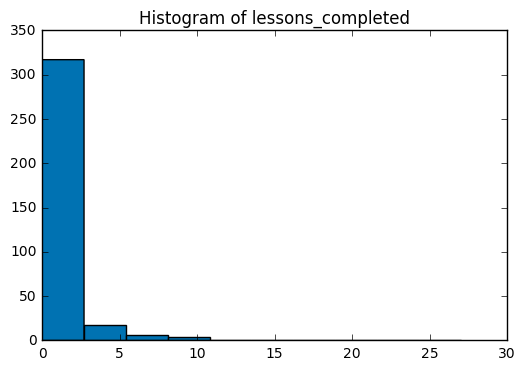

In [29]:
histogram('lessons_completed', eng_not_passed)

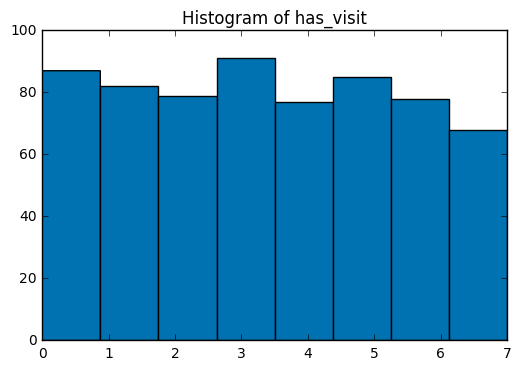

In [34]:
histogram('has_visit', eng_passed, bins=8)

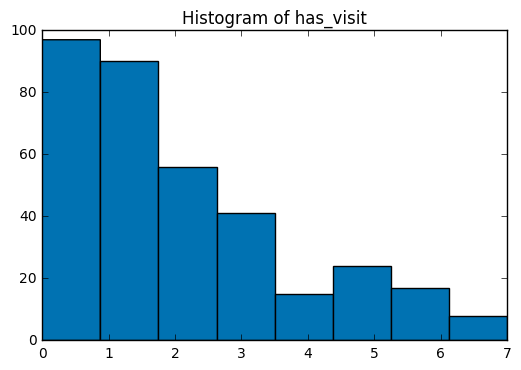

In [35]:
histogram('has_visit', eng_not_passed, bins=8)

```python
# adding label 
plt.xlabel("text")
plt.ylabel("text")
plt.title("plot title")
```